### Warm and Cold Events in the MITgcm runs forced by PACE
This document is made for the detection, characterisation and study of warm and cold events in MITgcm runs by Kaitlin.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from unixFunctionsMITgcm_final import read_all_data, show_selected_periods

#### Step 1: Definition and Detection
In order to find a warm or cold event in the MITgcm data, we need a detection limit. This has to be a physical limit, so that we can say something about the frequency of occurence.

In [4]:

#Reading the data.
full='/data/hpcdata/users/grejan/mitgcm/data'
total={}
units={}
longnames={}
total, units, longnames=read_all_data(full, total, units, longnames, kind='isotherm')
total, units, longnames=read_all_data(full, total, units, longnames, kind='final')

def findEvents(total=total, units=units, longnames=longnames, threshold=50, wvar='dotson_to_cosgrove_massloss', window=24,
               larger_than=True, method='mean', longwindow=12*25, min_periods=5*12,
               start='1920', end='2013'):
    
    #Create a long period running mean for detrending. We are interested in decadal variability.
    long=total[wvar][start:end].rolling(longwindow, min_periods=min_periods, center=True).mean()
    
    
    #threshold=np.nanpercentile(total[wvar][start:end].rolling(window, center=True).mean()-long, pct)
    #windows=[window]
    
    #Creat a dataframe with the selected time periods.
    selected=pd.DataFrame() 
    
    #Create arrays for the time axis
    a=[pd.to_datetime(str(j)) for j in np.arange(1920, 2011, 20)] 
    b=[str(j) for j in np.arange(1920, 2011, 20)]
    xlim=[1920,2020]
    
    lim=total[wvar][start:end].rolling(window, center=True).mean().std().mean()
    
    #Create figure
    plt.figure(figsize=(20,10))
    for i in range(len(total[wvar].columns)):    
        ax=plt.subplot(5,4,i+1)
        
        
        col=total[wvar].columns.sort_values()[i]
        series_dt=total[wvar][col][start:end].rolling(window, center=True).mean()-total[wvar][col][start:end].rolling(longwindow, min_periods=min_periods, center=True).mean()
        series_dt.plot()
        
        if larger_than==True:
            sel=series_dt>threshold
        elif larger_than==False:
            sel=series_dt<threshold
        
        selected[col]=sel
        for j in range(len(sel)):
            if (sel.iloc[j]==True) & (sel.iloc[j-1]==False):
                c=0
                while sel.iloc[j+c]==True:
                    c+=1       
                plt.axvspan(sel.index[j], sel.index[j+c-1], color='red', alpha=0.3)
        plt.hlines(0, pd.to_datetime('1910'), pd.to_datetime('2020'), colors='k', linestyles='dashed')
        plt.grid()
        plt.xlim([pd.to_datetime(str(k)) for k in xlim])
        
        plt.title(col)
        plt.ylabel(units[wvar])    
        plt.ylim([-lim*2.5, lim*2.5])
        plt.xticks(a,b)
        ax.grid(True)


    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    plt.suptitle(longnames[wvar]+';\n {} month rolling mean (centered)'.format(window)+'\n Threshold: {} in: '.format(str(threshold))+longnames[wvar])
    
    return selected, units

**Ideas of definitions**

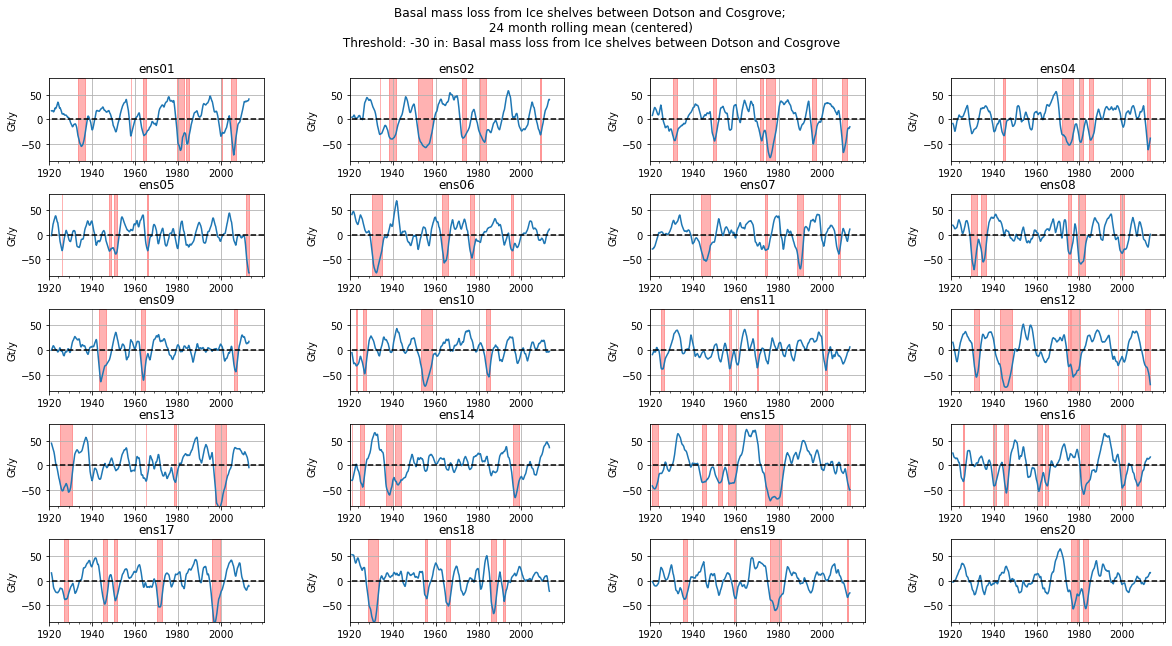

In [19]:
#High Melt Events
#selected,_=findEvents(threshold=20, wvar='dotson_to_cosgrove_massloss', larger_than=True) #Selects almost most of the positive anomalies
selected,_=findEvents(threshold=-30, wvar='dotson_to_cosgrove_massloss', larger_than=False)

#Warm Events
#selected,_=findEvents(threshold=-0.15, wvar='amundsen_shelf_temp_btw_200_700m', larger_than=False) #Select most peaks.

### Step 2: Describe these events
First, describe them statistically. Then, describe them physically.

ens01
ens02
ens03
ens04
ens05
ens06
ens07
ens08
ens09
ens10
ens11
ens12
ens13
ens14
ens15
ens16
ens17
ens18
ens19
ens20


/tmp/ipykernel_88576/300537840.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['max'].iloc[i]=ts_dt[events['col'].iloc[i]][events['start'].iloc[i]:events['stop'].iloc[i]].max()
/tmp/ipykernel_88576/300537840.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events['mean'].iloc[i]=ts_dt[events['col'].iloc[i]][events['start'].iloc[i]:events['stop'].iloc[i]].mean()
/tmp/ipykernel_88576/300537840.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

# of events:62


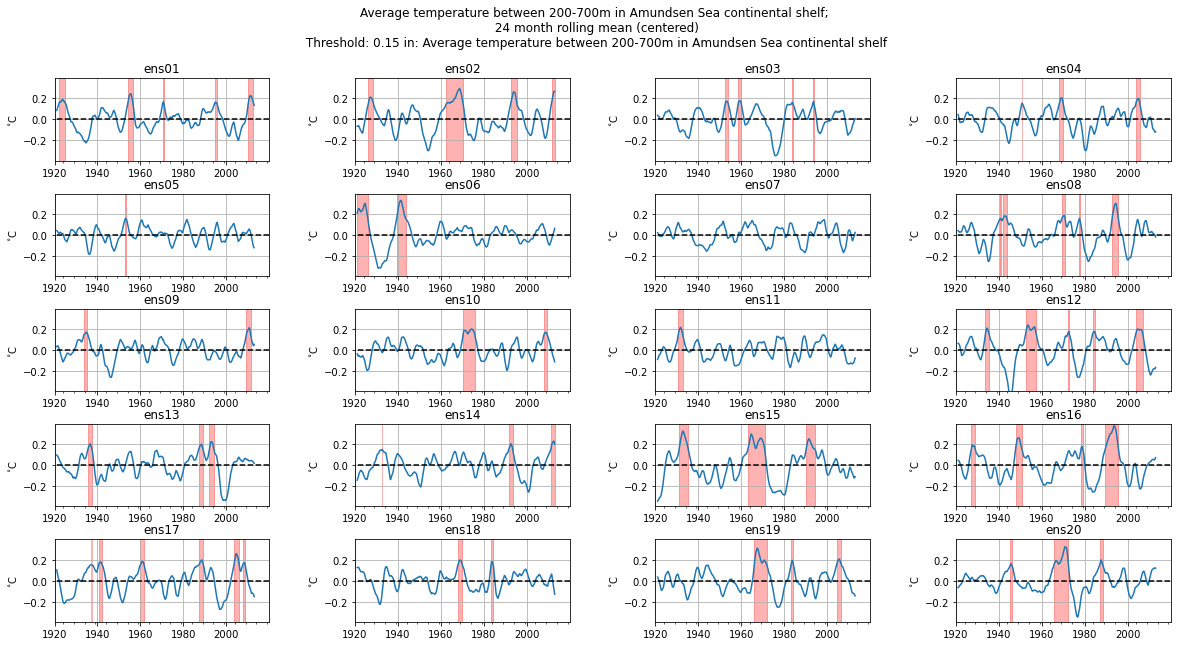

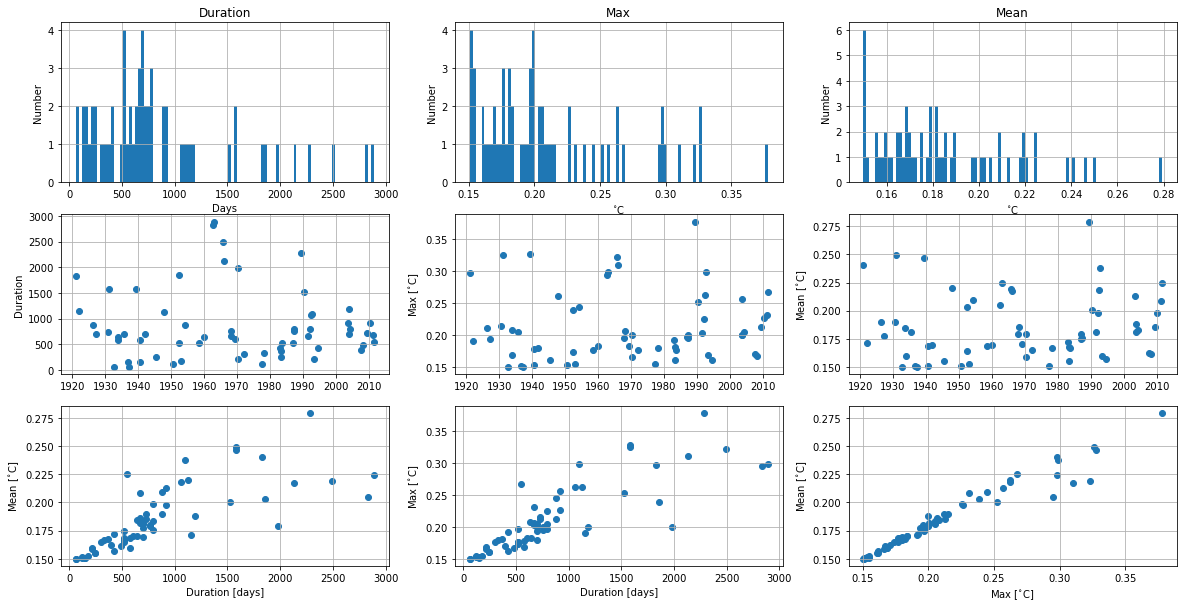

In [13]:
#Duration, intensity, statistical occurence, time between two events, spread over members.

def createEvents(selected):
    events=pd.DataFrame(columns=['col', 'start', 'stop'])
    for col in selected.columns:
        print(col)
        event_start=[]
        event_stop=[]
        for i in range(len(selected[col])):
            if (selected[col].iloc[i]==True) & (selected[col].iloc[i-1]==False):
                event_start+=[selected[col].index[i]]
            if (selected[col].iloc[i]==False) & (selected[col].iloc[i-1]==True):
                event_stop+=[selected[col].index[i]]
                
        new_events=pd.DataFrame()
        new_events['col']=[col,]*len(event_start)
        new_events['start']=event_start
        new_events['stop']=event_stop
        events=pd.concat([events, new_events], ignore_index=True)
    
    events['duration']=(events.stop-events.start)/np.timedelta64(1, 'D')
    #events['time2next']=(events.start.iloc[1:].values-events.stop.iloc[:-1].values)/np.timedelta64(1, 'D')
    return events

def describeEvents(selected, total=total, units=units, wvar='amundsen_shelf_temp_btw_200_700m', window=24, longwindow=12*25, min_periods=5*12, start='1920', end='2013'):
    
    ts_dt=total[wvar][start:end].rolling(window, center=True).mean()-total[wvar][start:end].rolling(longwindow, min_periods=min_periods, center=True).mean()
    
    
    events=createEvents(selected)
    
    events['max']=np.zeros(len(events))
    events['mean']=np.zeros(len(events))
    events['month']=np.zeros(len(events))
    for i in range(len(events)):
        events['max'].iloc[i]=ts_dt[events['col'].iloc[i]][events['start'].iloc[i]:events['stop'].iloc[i]].max()
        events['mean'].iloc[i]=ts_dt[events['col'].iloc[i]][events['start'].iloc[i]:events['stop'].iloc[i]].mean()
        events['month'].iloc[i]=events['start'].iloc[i].month
        
    plt.figure(figsize=(20,10))
    plt.subplot(3,3,1)
    events['duration'].hist(bins=100)
    plt.ylabel('Number')
    plt.title('Duration')
    plt.xlabel('Days')
    plt.grid(True)
    
    plt.subplot(3,3,2)
    events['max'].hist(bins=100)
    plt.ylabel('Number')
    plt.title('Max')
    plt.xlabel(units[wvar])
    plt.grid(True)
    
    plt.subplot(3,3,3)
    events['mean'].hist(bins=100)
    plt.ylabel('Number')
    plt.title('Mean')
    plt.xlabel(units[wvar])
    plt.grid(True)
    
    
    plt.subplot(3,3,4)
    plt.scatter(events['start'], events['duration'])
    plt.ylabel('Duration')
    plt.grid(True)
    
    plt.subplot(3,3,5)
    plt.scatter(events['start'], events['max'])
    plt.ylabel('Max ['+units[wvar]+']')
    plt.grid(True)
    
    plt.subplot(3,3,6)
    plt.scatter(events['start'], events['mean'])
    plt.ylabel('Mean ['+units[wvar]+']')
    plt.grid(True)
    
    plt.subplot(3,3,7)
    plt.scatter(events['duration'], events['mean'])
    plt.ylabel('Mean ['+units[wvar]+']')
    plt.xlabel('Duration [days]')
    plt.grid(True)
    
    plt.subplot(3,3,8)
    plt.scatter(events['duration'], events['max'])
    plt.ylabel('Max ['+units[wvar]+']')
    plt.xlabel('Duration [days]')
    plt.grid(True)
    
    plt.subplot(3,3,9)
    plt.scatter(events['max'], events['mean'])
    plt.xlabel('Max ['+units[wvar]+']')
    plt.ylabel('Mean ['+units[wvar]+']')
    #plt.xlabel('Duration [days]')
    plt.grid(True)

    
    
    return events



#events=describeEvents(wvar='dotson_to_cosgrove_massloss')

selected,_=findEvents(threshold=0.15, wvar='amundsen_shelf_temp_btw_200_700m', larger_than=True) #Select most peaks.
#selected,_=findEvents(threshold=20, wvar='dotson_to_cosgrove_massloss', larger_than=True)


events_temp=describeEvents(selected)
#events_melt=describeEvents(wvar='dotson_to_cosgrove_massloss')


print('# of events:'+str(len(events_temp)))



NameError: name 'events_melt' is not defined

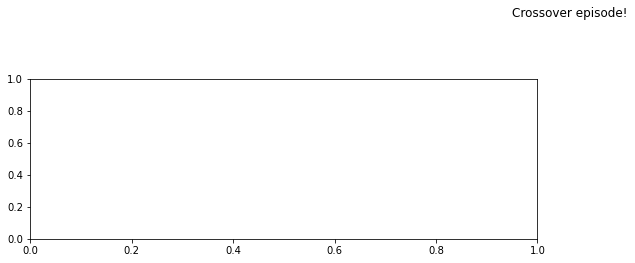

In [8]:
#To what do they correspond in other variables.
plt.figure(figsize=(20,10))
plt.suptitle('Crossover episode!')
plt.subplot(3,2,1)
plt.scatter(events_temp['mean'], events_melt['mean'])
plt.xlabel('Temperature')
plt.ylabel('Melt')
plt.title('Mean')
plt.grid(True)

plt.subplot(3,2,2)
plt.scatter(events_temp['max'], events_melt['max'])
plt.xlabel('Temperature')
plt.ylabel('Melt')
plt.title('Max')
plt.grid(True)



# Make Composite Maps

In [9]:
from unixFunctionsMITgcm_final import loadMITgcmData
members='all'
data=loadMITgcmData(filename='amundsen_shelf_temp_200to700', members=members)

Loading number:0
Loading number:1
Loading number:2
Loading number:3
Loading number:4
Loading number:5
Loading number:6
Loading number:7
Loading number:8
Loading number:9
Loading number:10
Loading number:11
Loading number:12
Loading number:13
Loading number:14
Loading number:15
Loading number:16
Loading number:17
Loading number:18
Loading number:19


In [10]:
from unixFunctionsMITgcm_final import detrend_and_average_MITgcmData
window=24
var='THETA'
data_dt=detrend_and_average_MITgcmData(data, var, window=window)

In [17]:
#from unixFunctionsMITgcm_final import makeCompositeAnimation, makeCompositeMap
def createCompositeMap2(data, selected, title='Composite map', 
                       filename='map', window=24, method='mean', 
                       longwindow=12*25, 
                       unit='[m/s]',
                       members='all', larger_than=True, pct=90): 
    
    def month_diff(a, b):
        return round(((a - b)/np.timedelta64(1, 'M')))
    
    #Find the start date per ensemble member.
    start_list=pd.DataFrame()
    for ens in selected.columns:
        start=np.array([False,]*len(selected[ens]))
        for i in range(len(selected[ens])):
            if (selected[ens].iloc[i]==True) & (selected[ens].iloc[i-1]==False):
                start[i]=True
        start_list[ens]=pd.Series(start, index=selected[ens].index)
    
    
    #Load the correct data and give it a relative time name.
    columns=start_list.columns
    columns=columns.sort_values()
    
    for i, ens in enumerate(columns):
        print('Ens is: '+str(ens))
        years=start_list[ens][start_list[ens]==True].index.year.values
        for year in years:
            a=data.sel(ens=i).sel(time=slice(str(year-2), str(year)))
            if year==years[0]:
                b=a
            else:
                b=xr.concat([b,a], dim='time')
                
        times=b.indexes['time'].to_datetimeindex()

        reltime=np.ones(len(times))*99 #relative time to the the starting month [months]

        kappa=0
        for iota, t in enumerate(times):
            if start_list[ens][start_list[ens]==True].index[kappa].year>=t.year:
                reltime[iota]=month_diff(t, start_list[ens][start_list[ens]==True].index[kappa])
            else:
                kappa+=1
                reltime[iota]=month_diff(t, start_list[ens][start_list[ens]==True].index[kappa])

        b['time']=reltime        
                
        
        if i==0:
            data_new=b
        else:
            data_new=xr.concat([data_new,b], dim='time')
            
            
    #Completing the title
    title=title+'\n (both {} month moving average,'.format(str(window))
    if method=='linear':
        title+=' linearly detrended)'
    elif method=='quadratic':
        title+=' quadratically detrended)'
    elif method=='mean':
        title+='  detrended with {} month rolling mean)'.format(str(longwindow))
    if members=='all':
        title+=' (full ensemble)'
    else:
        title+=' ({} members)'.format(str(members[-1]-members[0]))
    
    print('Starting with plotting')
    #When data is read, let's start with the plotting!
    #makeCompositeMap(data=data_new, months=[-25,3], title=title, filename=filename, unit=unit, 
    #                 pct=pct, larger_than=larger_than)
    makeCompositeAnimation(data=data_new, months=[-25,3], title=title, filename=filename, unit=unit, 
                           pct=pct, larger_than=larger_than)
    
    print('Finished!')
    
    return

In [22]:
def makeCompositeAnimation(data, months=[-25,5], show_box=True, title='Composite map or not',
                           filename='map',
                           vmin_pct=0.3, vmax_pct=0.7,
                           gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/',
                           unit='[m/s]',
                           region='amundsen_sea', wvar='dotson_to_cosgrove_massloss', pct=90, larger_than=True):
    
    #From my code to Kaitlin's code
    from mitgcm_python_master.plot_latlon import latlon_plot
    from mitgcm_python_master.grid import ERA5Grid, PACEGrid, Grid, dA_from_latlon, pierre_obs_grid
    from mitgcm_python_master.utils import real_dir, daily_to_monthly, fix_lon_range, split_longitude, mask_land_ice, moving_average, index_year_start, index_year_end, index_period, mask_2d_to_3d, days_per_month, add_time_dim, z_to_xyz, select_bottom, convert_ismr, mask_except_ice, xy_to_xyz, apply_mask, var_min_max, mask_3d, average_12_months, depth_of_isoline, mask_land, axis_edges
    from mitgcm_python_master.plot_utils.latlon import shade_mask, overlay_vectors
    from mitgcm_python_master.plot_utils.windows import finished_plot, set_panels
    from matplotlib.animation import FuncAnimation
    import matplotlib.animation as animation
    
    fig, ax=plt.subplots(figsize=(14,5))
    moi=months[0]
    
    #if len(np.shape(data))==4:
    #    print('hoi')
    cors=data.sel(time=moi).mean(dim='events')
    #else:
    #    cors=data.sel(time=moi).mean(dim='time')
    try:
        cors=cors.to_array().to_numpy()[:,:]
    except:
        cors=cors.to_numpy()[:,:]
    
    grid = Grid(gp)
    region=region
    mask = grid.get_region_mask(region)
    mask=mask.astype(bool)

    vmax=data.quantile(vmax_pct).to_numpy()
    vmin=data.quantile(vmin_pct).to_numpy()

    #Prepare everything for the map!
    r_data = np.zeros([grid.ny, grid.nx])
    r_data[mask] = cors[mask]
    r_data = mask_land_ice(r_data, grid)
    r_data[np.isnan(r_data)]=0
    if larger_than==True:
        title_new=title+'\n (time since time of detection: {} months, threshold: above {} percentile of {})'.format(str(moi), str(pct), wvar)
    else:
        title_new=title+'\n (time since time of detection: {} months, threshold: below {} percentile of {})'.format(str(moi), str(pct), wvar)

    #Plot the Map
    img=latlon_plot(r_data, grid, ctype='plusminus', vmin=vmin, vmax=vmax, title=title_new, titlesize=14, figsize=(14,5), ax=ax, make_cbar=False)
    cbar = plt.colorbar(img)

    cbar.ax.set_ylabel(unit, rotation=270)

    bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
    plt.clabel(bath, [-1000])

    show_box=True
    if show_box==True:
        x=[-115, -102, -102, -115, -115]
        y=[-71.8, -71.8, -70.2,  -70.2, -71.8] 
        ax.plot(x, y, c='g', marker='o')


    # animation function
    def animate(i):
        print(i)
        moi=i-25


        cors=data.sel(time=moi).mean(dim='events')
        try:
            cors=cors.to_array().to_numpy()[:,:]
        except:
            cors=cors.to_numpy()[:,:]

        #Prepare everything for the map!
        r_data = np.zeros([grid.ny, grid.nx])
        r_data[mask] = cors[mask]
        r_data = mask_land_ice(r_data, grid)
        r_data[np.isnan(r_data)]=0

        if larger_than==True:
            title_new=title+'\n (time since time of detection: {} months, threshold: above {} percentile of {})'.format(str(moi), str(pct), wvar)
        else:
            title_new=title+'\n (time since time of detection: {} months, threshold: below {} percentile of {})'.format(str(moi), str(pct), wvar)

        #Plot the Map
        img=latlon_plot(r_data, grid, ctype='plusminus', vmin=vmin, vmax=vmax, title=title_new, titlesize=14, figsize=(14,5), ax=ax, make_cbar=False)

        bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
        plt.clabel(bath, [-1000])

        show_box=True
        if show_box==True:
            x=[-115, -102, -102, -115, -115]
            y=[-71.8, -71.8, -70.2,  -70.2, -71.8] 
            ax.plot(x, y, c='g', marker='o')

        return 

    
    from datetime import date
    today = date.today()
    today=today.strftime("%Y%m%d")
    
    anim = animation.FuncAnimation(fig, animate, frames=months[-1]-months[0], repeat=False, interval=5000)
    writergif = animation.PillowWriter(fps=2)
    anim.save('./figures/animation_composite_'+filename+'_'+today+'.gif', writer=writergif)
    return



def createCompositeMap3(data, selected, title='Composite map', 
                       filename='map', window=24, method='mean', 
                       longwindow=12*25, 
                       unit='[m/s]',
                       members='all', larger_than=True, pct=90, startyr='1920', endyr='2013', months=[-25, 10]): 
    
    #from unixFunctionsMITgcm_final import makeCompositeAnimation, makeCompositeMap
    
    def month_diff(a, b):
        return round(((a - b)/np.timedelta64(1, 'M')))
    
    #Find the start date per ensemble member.
    start_list=pd.DataFrame()
    for ens in selected.columns:
        start=np.array([False,]*len(selected[ens]))
        for i in range(len(selected[ens])):
            if (selected[ens].iloc[i]==True) & (selected[ens].iloc[i-1]==False):
                start[i]=True
        start_list[ens]=pd.Series(start, index=selected[ens].index)
    
    
    #Load the correct data and give it a relative time name.
    columns=start_list.columns
    columns=columns.sort_values()
    
    
    months=np.arange(months[0], months[-1])
    
    data_new=None
    for month in months:
        b=None
        print('Month is:'+str(month))
        for ensnum, col in enumerate(columns):
            #print(col)
            #print(ensnum)
            true_list=start_list[col][start_list[col]==True]
            for i in range(len(true_list)):
                timestring=(true_list.index[i]+pd.DateOffset(months=month))

                if (timestring<pd.to_datetime(startyr)) | (timestring>pd.to_datetime(endyr)):
                    timestring=true_list.index[i].strftime('%Y-%m-%d')
                    a=data.sel(ens=ensnum).sel(time=timestring)*np.nan
                else:
                    timestring=timestring.strftime('%Y-%m-%d')
                    a=data.sel(ens=ensnum).sel(time=timestring)
                a['time']=[month]
                if type(b)==type(None):
                    b=a
                else:
                    b=xr.concat([b,a], dim='events')
        if type(data_new)==type(None):
            data_new=b
        else:
            data_new=xr.concat([data_new, b], dim='time')
    
    
#     for i, ens in enumerate(columns):
#         print('Ens is: '+str(ens))
#         years=start_list[ens][start_list[ens]==True].index.year.values
#         for year in years:
#             a=data.sel(ens=0).sel(time=slice(str(year-2), str(year)))
#             if year==years[0]:
#                 b=a
#             else:
#                 b=xr.concat([b,a], dim='time')
                
#         times=b.indexes['time'].to_datetimeindex()

#         reltime=np.ones(len(times))*99 #relative time to the the starting month [months]

#         kappa=0
#         for iota, t in enumerate(times):
#             if start_list[ens][start_list[ens]==True].index[kappa].year>=t.year:
#                 reltime[iota]=month_diff(t, start_list[ens][start_list[ens]==True].index[kappa])
#             else:
#                 kappa+=1
#                 reltime[iota]=month_diff(t, start_list[ens][start_list[ens]==True].index[kappa])

#         b['time']=reltime        
                
        
#         if i==0:
#             data_new=b
#         else:
#             data_new=xr.concat([data_new,b], dim='time')
            
            
    #Completing the title
    title=title+'\n (both {} month moving average,'.format(str(window))
    if method=='linear':
        title+=' linearly detrended)'
    elif method=='quadratic':
        title+=' quadratically detrended)'
    elif method=='mean':
        title+='  detrended with {} month rolling mean)'.format(str(longwindow))
    if members=='all':
        title+=' (full ensemble)'
    else:
        title+=' ({} members)'.format(str(members[-1]-members[0]))
    
    print('Starting with plotting')
    #When data is read, let's start with the plotting!
    #makeCompositeMap(data=data_new, months=[-25,3], title=title, filename=filename, unit=unit, 
    #                 pct=pct, larger_than=larger_than)
    makeCompositeAnimation(data=data_new, months=[months[0],months[-1]], title=title, filename=filename, unit=unit, 
                           pct=pct, larger_than=larger_than)
    
    print('Finished!')
    return

Month is:-25
Month is:-24
Month is:-23
Month is:-22
Month is:-21
Month is:-20
Month is:-19
Month is:-18
Month is:-17
Month is:-16
Month is:-15
Month is:-14
Month is:-13
Month is:-12
Month is:-11
Month is:-10
Month is:-9
Month is:-8
Month is:-7
Month is:-6
Month is:-5
Month is:-4
Month is:-3
Month is:-2
Month is:-1
Month is:0
Month is:1
Month is:2
Starting with plotting


/users/kaight/MITgcm/utils/python/MITgcmutils/MITgcmutils/netcdf.py:330: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if hasattr(self, 'mode') and self.mode is 'w':
/users/kaight/MITgcm/utils/python/MITgcmutils/MITgcmutils/netcdf.py:705: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if typecode is not 'c':
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


0


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


0


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


1


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


2


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


3


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


4


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


5


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


6


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


7


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


8


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


9


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


10


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


11


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


12


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


13


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


14


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


15


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


16


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


17


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


18


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


19


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


20


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


21


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


22


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


23


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


24


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


25


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


26


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


27


/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lon_labels)
/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:133: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lat_labels)


Finished!


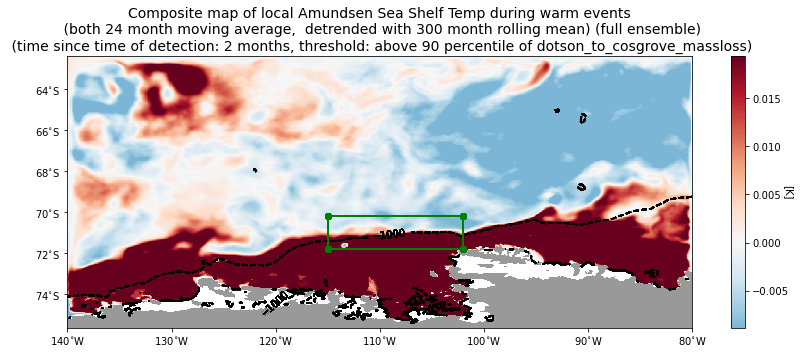

In [23]:
data_new=createCompositeMap3(data_dt, selected, title='Composite map of local Amundsen Sea Shelf Temp during warm events', 
                    filename='24monthmean_amundsenshelftemp_test_map3',
                    unit='[K]',
                    window=window)

### Tests and Trash

In [19]:
makeCompositeAnimation

<function __main__.makeCompositeAnimation(data, months=[-25, 5], show_box=True, title='Composite map or not', filename='map', vmin_pct=0.3, vmax_pct=0.7, gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/', unit='[m/s]', region='amundsen_sea', wvar='dotson_to_cosgrove_massloss', pct=90, larger_than=True)>

In [186]:
start_list=pd.DataFrame()
for ens in selected.columns:
    start=np.array([False,]*len(selected[ens]))
    for i in range(len(selected[ens])):
        if (selected[ens].iloc[i]==True) & (selected[ens].iloc[i-1]==False):
            start[i]=True
    start_list[ens]=pd.Series(start, index=selected[ens].index)

In [257]:
start_list['ens01'][start_list['ens01']==True].index[0]

Timestamp('1921-04-01 00:00:00')

In [202]:

print(start_list['ens01'][start_list['ens01']==True].index[0])

print(start_list['ens01'][start_list['ens01']==True].index[0]+pd.DateOffset(month=2))


print(start_list['ens01'][start_list['ens01']==True].index[0]-pd.DateOffset(month=2))

1921-04-01 00:00:00
1921-02-01 00:00:00
1921-02-01 00:00:00


In [209]:
q=(start_list['ens01'][start_list['ens01']==True].index[0]+pd.DateOffset(months=2)).strftime('%Y-%m-%d')

In [210]:
data_dt.sel(ens=0).sel(time=q)

<xarray.DataArray 'THETA' (time: 1, YC: 384, XC: 600)>
array([[[ 3.5762787e-07,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  1.4901161e-06],
        [-3.8743019e-07,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  3.5762787e-07],
        [-4.4703484e-07,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00, -1.5497208e-06],
        ...,
        [ 3.3378601e-06,  1.2944937e-03,  6.4635277e-04, ...,
          5.8443546e-03,  3.8363934e-03,  2.6226044e-06],
        [-3.5762787e-07,  8.6283684e-04,  6.9475174e-04, ...,
          3.1580925e-03,  1.2228489e-03,  9.5367432e-07],
        [-2.0265579e-06, -2.1457672e-06,  2.1457672e-06, ...,
         -3.3378601e-06, -3.0994415e-06,  1.6689301e-06]]], dtype=float32)
Coordinates:
    iter     (time) int64 1651104
  * time     (time) object 1921-06-01 00:00:00
  * XC       (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
  * YC       (YC) float32 -75.64 -75.61 -75.59 -75.56 ... -62.48 -62.44 -62.39
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 4.71e+03 4.683e+03 4.673e+03
    rA       (YC, XC) float32 7.604e+06 7.604e+06 ... 2.652e+07 2.652e+07

In [292]:
start_list[col]

1920-01-01    False
1920-02-01    False
1920-03-01    False
1920-04-01    False
1920-05-01    False
              ...  
2013-08-01    False
2013-09-01    False
2013-10-01    False
2013-11-01    False
2013-12-01    False
Name: ens20, Length: 1128, dtype: bool

In [212]:
ds = xr.Dataset({"foo": (("x", "y", "z"), [[[42]]]), "bar": (("y", "z"), [[24]])})

In [217]:
ds.expand_dims('ens')
ds['ens']=7

In [218]:
ds

<xarray.Dataset>
Dimensions:  (x: 1, y: 1, z: 1)
Dimensions without coordinates: x, y, z
Data variables:
    foo      (x, y, z) int64 42
    bar      (y, z) int64 24
    ens      int64 7

In [219]:
data_dt

<xarray.DataArray 'THETA' (ens: 20, time: 1128, YC: 384, XC: 600)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    iter     (time) int64 1576800 1581264 1585296 ... 6504192 6508656 6512976
  * time     (time) object 1920-01-01 00:00:00 ... 2013-12-01 00:00:00
  * XC       (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
  * YC       (YC) float32 -75.64 -75.61 -75.59 -75.56 ... -62.48 -62.44 -62.39
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 4.71e+03 4.683e+03 4.673e+03
    rA       (YC, XC) float32 7.604e+06 7.604e+06 ... 2.652e+07 2.652e+07
Dimensions without coordinates: ens

In [235]:
z=data.sel(ens=1)
g=data.sel(ens=3)
z

<xarray.Dataset>
Dimensions:  (time: 1488, YC: 384, XC: 600)
Coordinates:
    iter     (time) int64 4464 8496 12960 17280 ... 6508656 6512976 6517440
  * time     (time) object 1890-02-01 00:00:00 ... 2014-01-01 00:00:00
  * XC       (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
  * YC       (YC) float32 -75.64 -75.61 -75.59 -75.56 ... -62.48 -62.44 -62.39
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 4.71e+03 4.683e+03 4.673e+03
    rA       (YC, XC) float32 7.604e+06 7.604e+06 ... 2.652e+07 2.652e+07
Data variables:
    THETA    (time, YC, XC) float32 -0.0555 0.0 0.0 0.0 ... 2.092 2.093 2.116

In [236]:
z=z.expand_dims('ens')
z
z['ens']=[99]


g=g.expand_dims('ens')
g['ens']=[18]
g

<xarray.Dataset>
Dimensions:  (ens: 1, time: 1488, YC: 384, XC: 600)
Coordinates:
    iter     (time) int64 4464 8496 12960 17280 ... 6508656 6512976 6517440
  * time     (time) object 1890-02-01 00:00:00 ... 2014-01-01 00:00:00
  * XC       (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
  * YC       (YC) float32 -75.64 -75.61 -75.59 -75.56 ... -62.48 -62.44 -62.39
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 4.71e+03 4.683e+03 4.673e+03
    rA       (YC, XC) float32 7.604e+06 7.604e+06 ... 2.652e+07 2.652e+07
  * ens      (ens) int64 18
Data variables:
    THETA    (ens, time, YC, XC) float32 -0.0555 0.0 0.0 ... 2.092 2.093 2.116

In [237]:
xr.concat([g,z], dim='ens')

<xarray.Dataset>
Dimensions:  (ens: 2, time: 1488, YC: 384, XC: 600)
Coordinates:
    iter     (time) int64 4464 8496 12960 17280 ... 6508656 6512976 6517440
  * time     (time) object 1890-02-01 00:00:00 ... 2014-01-01 00:00:00
  * XC       (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
  * YC       (YC) float32 -75.64 -75.61 -75.59 -75.56 ... -62.48 -62.44 -62.39
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 4.71e+03 4.683e+03 4.673e+03
    rA       (YC, XC) float32 7.604e+06 7.604e+06 ... 2.652e+07 2.652e+07
  * ens      (ens) int64 18 99
Data variables:
    THETA    (ens, time, YC, XC) float32 -0.0555 0.0 0.0 ... 2.092 2.093 2.116

In [251]:
start_list[col][start_list[col]==True]

1944-02-01    True
1964-11-01    True
1986-02-01    True
1997-08-01    True
2011-05-01    True
Name: ens20, dtype: bool

In [245]:
col='ens20'

In [248]:
start_list[col]

1920-01-01    False
1920-02-01    False
1920-03-01    False
1920-04-01    False
1920-05-01    False
              ...  
2013-08-01    False
2013-09-01    False
2013-10-01    False
2013-11-01    False
2013-12-01    False
Name: ens20, Length: 1128, dtype: bool

In [294]:
data_new.time

<xarray.DataArray 'time' (time: 8)>
array([-5, -4, -3, -2, -1,  0,  1,  2])
Coordinates:
  * time     (time) int64 -5 -4 -3 -2 -1 0 1 2

In [283]:
z*np.nan

<xarray.Dataset>
Dimensions:  (time: 1488, XC: 600, YC: 384, ens: 1)
Coordinates:
    iter     (time) int64 4464 8496 12960 17280 ... 6508656 6512976 6517440
  * time     (time) object 1890-02-01 00:00:00 ... 2014-01-01 00:00:00
  * XC       (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
  * YC       (YC) float32 -75.64 -75.61 -75.59 -75.56 ... -62.48 -62.44 -62.39
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 4.71e+03 4.683e+03 4.673e+03
    rA       (YC, XC) float32 7.604e+06 7.604e+06 ... 2.652e+07 2.652e+07
  * ens      (ens) int64 99
Data variables:
    THETA    (ens, time, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan

In [336]:
import unixFunctionsMITgcm_final as fc
members=[0,1]
var='EXFuwind'
data_test=fc.readMITgcmData(var=var, members=members)

/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_35532/1000177368.py", line 4, in <module>
    data_test=fc.readMITgcmData(var=var, members=members)
  File "/data/hpcdata/users/grejan/mitgcm/unixFunctionsMITgcm_final.py", line 52, in readMITgcmData
    b=xr.concat([b,a], dim='time')
  File "/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/concat.py", line 242, in concat
    return f(
  File "/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/concat.py", line 521, in _dataset_concat
    combined = concat_vars(vars, dim, positions, combine_attrs=combine_attrs)
  File "/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/variable.py", line 2936, in concat
    return Variable.concat(variables, dim, positions, shortcut, combine_attrs)


TypeError: object of type 'NoneType' has no len()

In [ ]:
data_real=loadMITgcmData(var, members)

In [3]:
import os

In [10]:
os.listdir('/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01/output/194001/MITgcm')

['STDERR.0000',
 'STDOUT.0000',
 'bathymetry_bedmach.bin',
 'data',
 'data.diagnostics',
 'output.nc',
 'panom.bin',
 'pickup.0002628000.data',
 'pickup.0002628000.meta',
 'pickup.0002680560.data',
 'pickup.0002680560.meta',
 'pickup_seaice.0002628000.data',
 'pickup_seaice.0002628000.meta',
 'pickup_seaice.0002680560.data',
 'pickup_seaice.0002680560.meta',
 'shelfice.bin']

In [12]:
a=xr.open_dataset('/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01/output/194001/MITgcm/output.nc')

In [14]:
a.Z

<xarray.DataArray 'Z' (Z: 50)>
array([-5.0000e+00, -1.5000e+01, -2.5000e+01, -3.5000e+01, -4.6000e+01,
       -5.9250e+01, -7.5250e+01, -9.4500e+01, -1.1750e+02, -1.4500e+02,
       -1.7750e+02, -2.1500e+02, -2.5750e+02, -3.0500e+02, -3.5500e+02,
       -4.0500e+02, -4.5500e+02, -5.0500e+02, -5.5500e+02, -6.0500e+02,
       -6.5500e+02, -7.0500e+02, -7.5500e+02, -8.0500e+02, -8.5500e+02,
       -9.0500e+02, -9.5500e+02, -1.0050e+03, -1.0550e+03, -1.1100e+03,
       -1.1750e+03, -1.2500e+03, -1.3350e+03, -1.4325e+03, -1.5475e+03,
       -1.6850e+03, -1.8475e+03, -2.0350e+03, -2.2475e+03, -2.4850e+03,
       -2.7600e+03, -3.0600e+03, -3.3600e+03, -3.6600e+03, -3.9600e+03,
       -4.2600e+03, -4.5600e+03, -4.8600e+03, -5.1600e+03, -5.4600e+03],
      dtype=float32)
Coordinates:
  * Z        (Z) float32 -5.0 -15.0 -25.0 ... -4.86e+03 -5.16e+03 -5.46e+03
    PHrefC   (Z) float32 49.05 147.1 245.2 ... 4.768e+04 5.062e+04 5.356e+04
    drF      (Z) float32 10.0 10.0 10.0 10.0 12.0 ... 300.0 300.0 300.0 300.0
Attributes:
    units:          m
    positive:       down
    standard_name:  depth
    long_name:      vertical coordinate of cell center
    axis:           Z

In [20]:
a.THETA.values[0,:,150,150]

array([ 2.803876  ,  2.5306504 ,  1.4563501 ,  0.00346301, -1.1948043 ,
       -1.6757325 , -1.7698861 , -1.7668257 , -1.5076091 , -0.8294649 ,
        0.07314842,  1.0037644 ,  1.521474  ,  1.645692  ,  1.675282  ,
        1.673859  ,  1.6466092 ,  1.6012894 ,  1.5580671 ,  1.5170088 ,
        1.476139  ,  1.4349362 ,  1.3939341 ,  1.3537439 ,  1.3152344 ,
        1.2775886 ,  1.2394898 ,  1.2016417 ,  1.1639756 ,  1.1229067 ,
        1.0765567 ,  1.0253772 ,  0.9695364 ,  0.9078229 ,  0.8388306 ,
        0.76205075,  0.6794861 ,  0.588601  ,  0.49331567,  0.3975055 ,
        0.30080366,  0.23815188,  0.20563284,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
      dtype=float32)

In [28]:
selected[selected==True]=False
selected.loc['1941-01']=True

In [30]:
selected['1939':'1941']

,ens01,ens02,ens03,ens04,ens05,ens06,ens07,ens08,ens09,ens10,ens11,ens12,ens13,ens14,ens15,ens16,ens17,ens18,ens19,ens20
1939-01-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1939-02-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1939-03-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1939-04-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1939-05-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1939-06-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1939-07-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1939-08-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1939-09-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1939-10-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
